In [2]:
import numpy as np 
import pandas as pd 
import os 
import cv2
import matplotlib.pyplot as plt 


In [5]:
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import *
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as k


In [17]:
Img_path = "C:\\Users\\USER\\Downloads\\DL\\Dataset\\lungs_CT\\lungs_CT\\2d_images\\"
Mask_path = "C:\\Users\\USER\\Downloads\\DL\\Dataset\\lungs_CT\\lungs_CT\\2d_masks\\"
Img_height, Img_width= 32, 32
Seed= 42

In [18]:
all_images = [x for x in sorted(os.listdir(Img_path)) if x[-4:] == ".tif"]
all_masks =  [x for x in sorted(os.listdir(Mask_path)) if x[-4:] == '.tif']
print(all_images.__len__())
print(all_masks.__len__())

267
267


In [20]:
X_data  = np.empty((len(all_images), Img_height, Img_width), dtype='float32')
print(X_data.shape)
for i, name in enumerate(all_images):
    im = cv2.imread(Img_path+name, cv2.IMREAD_UNCHANGED).astype('int16').astype('float32')
    im = cv2.resize(im, dsize=(Img_width, Img_height), interpolation= cv2.INTER_LANCZOS4)
    img = (im - np.min(im)) / (np.max(im) - np.min(im))
    X_data[i] = img

Y_data = np.empty((len(all_images), Img_height, Img_width), dtype='float32')
print(Y_data.shape)
for i, name in enumerate(all_images):
    im = cv2.imread(Mask_path+name, cv2.IMREAD_UNCHANGED).astype('float32')/255
    im = cv2.resize(im, dsize=(Img_width, Img_height), interpolation= cv2.INTER_NEAREST)
    Y_data[i] = im

(267, 32, 32)
(267, 32, 32)


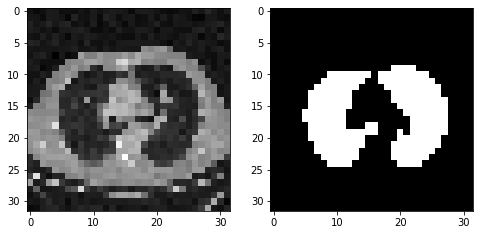

In [21]:
fig, ax  = plt.subplots(1, 2, figsize=(8,4))
ax[0].imshow(X_data[0], cmap='gray')
ax[1].imshow(Y_data[0], cmap='gray')
plt.show()

In [22]:
X_data = X_data[:,:,:,np.newaxis]
Y_data = Y_data[:,:,:,np.newaxis]
print(X_data.shape)


(267, 32, 32, 1)


In [23]:
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.5)

In [24]:
print(X_train.shape, X_test.shape)

(133, 32, 32, 1) (134, 32, 32, 1)


In [25]:
input_layer  = Input(shape=X_train.shape[1:])
c1 = Conv2D(filters=8, kernel_size=(3,3), activation = 'relu', padding = 'same')(input_layer)
l = MaxPool2D(strides=(2,2))(c1)
c2 = Conv2D(filters=16, kernel_size=(3,3), activation = 'relu', padding = 'same')(l)
l = MaxPool2D(strides=(2,2))(c2)
c3 = Conv2D(filters=32, kernel_size=(3,3), activation = 'relu', padding = 'same')(l)
l = MaxPool2D(strides=(2,2))(c3)
c4 = Conv2D(filters=64, kernel_size=(1,1), activation = 'relu', padding = 'same')(l)
l = concatenate([UpSampling2D(size=(2,2))(c4), c3], axis=-1)
l = Conv2D(filters=64, kernel_size=(2,2), activation ='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(l), c2], axis=-1)
l = Conv2D(filters=32, kernel_size=(2,2), activation ='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(l), c1], axis=-1)
l = Conv2D(filters=16, kernel_size=(2,2), activation ='relu', padding='same')(l)
l  = Conv2D(filters=64, kernel_size=(1,1), activation ='relu')(l)
l = Dropout(0.5)(l)
output_layer = Conv2D(filters=1, kernel_size=(1,1), activation='sigmoid')(l)
model  = Model(input_layer, output_layer)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [26]:
def my_generator(X_train, Y_train, batch_size):
    data_generator = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    rotation_range=10,
    zoom_range=0.1).flow(X_train, X_train, batch_size, seed=Seed)
    
    mask_generator  = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    rotation_range=10,
    zoom_range=0.1).flow(Y_train, Y_train, batch_size, seed=Seed)
    
    while True:
        x_batch, _ = data_generator.next()
        y_batch, _ = mask_generator.next()
        yield x_batch, y_batch

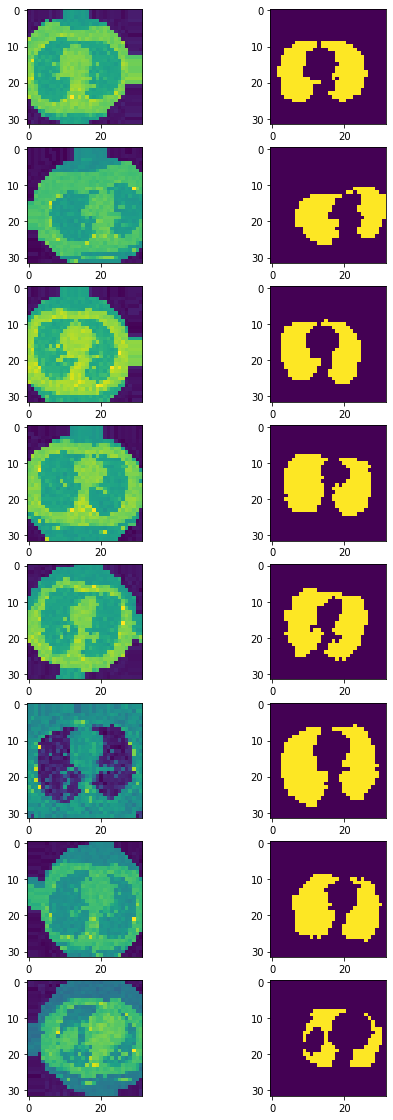

In [28]:
image_batch, mask_batch = next(my_generator(X_train,Y_train, 8))
fig, ax = plt.subplots(8, 2, figsize=(8, 20))
for i in range(8):
    ax[i, 0].imshow(image_batch[i, :,:, 0])
    ax[i, 1].imshow(mask_batch[i, :, :, 0])
plt.show()